# Stress Testing Common XAI Algos in the Literature

In [2]:
import pandas as pd
import numpy as np
import lime
import os
import numpy as np

from classifiers.ClassifierWrapper import ClassifierWrapper
from classifiers.XGBoost import XGBoost
from classifiers.BNetClassifier import BayesNet
from classifiers.NeuralNet import NeuralNetwork


import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import display, HTML

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline

import pyAgrum as gum
import pyAgrum.lib.notebook as gnb


SMALL_SIZE = 10
MEDIUM_SIZE = 12
plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=MEDIUM_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.rcParams['figure.dpi']=150

sns.set()

## Case #1: Data Generated from a Common Cause Structure with Independent Vars

The purpose of this test is to understand how current algorithms of the literature such as LIME and SHAP can represent feature in important in situations where data is generated from a common cause structure. We also added an independent variable to understand if this variable will be considered as relevant to the algorithm. We will train an XGboost classifier with data generated from the model below and run XAI algortihms to understand the computed feature importance.

<img src="https://raw.githubusercontent.com/catarina-moreira/XAI_Algos/0de91f13187c7a136676e049804c6b6e4de3ff44/networks/common_cause.png" />

In [3]:
# load the common cause data
data_common_cause = pd.read_csv(os.path.join("gen_data", "common_cause_v3.dat"))
data_common_cause.head()

,X1,X2,Y
0,0.162166,0,0
1,0.724821,1,0
2,0.784591,1,1
3,0.216756,0,0
4,0.828123,0,1


In [ ]:
clf_NNet = 

In [3]:
clf_BNet = BayesNet(False, "common_cause_v3", data_common_cause,"Y")
clf_BNet.classify(save_model=False, learningMethod="GHC")


Overall Performace: 
	Classifier: Bayesian Network
	Accuracy: 1.0
	Precision: 1.0
	Recall: 1.0
	F1 Score: 1.0


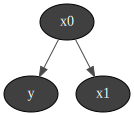

In [4]:
clf_BNet.show_bn()

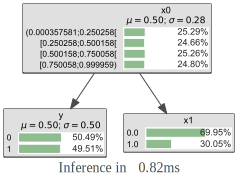

In [5]:
clf_BNet.show_query_mode()

In [ ]:
# generate instances to explain
df_expl = gum.generateSample(clf_BNet.getBN(), n=10, name_out=None, show_progress=False, with_labels=True, random_order=True)
df_expl[0].to_csv(os.path.join("gen_data", "common_cause_v3.csv"))


In [ ]:
clf_BNet.explainShapCondInd()


In [8]:
import time

from pyAgrum.lib.bn2graph import BN2dot
import numpy as np
import pandas as pd

import pyAgrum as gum
import pyAgrum.lib.notebook as gnb
import pyAgrum.lib.explain as expl

import matplotlib.pyplot as plt

In [ ]:
template=gum.fastBN("X1->X2->Y;X3->Z->Y;X0->Z;X1->Z;X2->R[5];Z->R;X1->Y")
data_path = "res/shap/Data_6var_direct_indirect.csv"

#gum.generateSample(template,1000,data_path)

learner = gum.BNLearner(data_path,template)
bn = learner.learnParameters(template.dag())
bn

In [ ]:
clf_xgboost = XGBoost(False, "common_cause_v3", data_common_cause,"Y")
clf_xgboost.classify()

In [ ]:
clf_bn = Classifier("Bayesian Network", "common_cause_v2", data_common_cause, "Y")
bnc = clf_bn.applyClassifer(learningMethod="GHC")


In [ ]:
gnb.showBN(bnc.bn)

In [ ]:
gnb.showInference(bnc.bn)

In [ ]:
clf_nn = Classifier("Neural Network", "common_cause_v2", data_common_cause, "Y")
NN = clf_nn.applyClassifer()
NN


### Training a Neural Network Classifier


In [ ]:
logs = pd.DataFrame(history.history)

plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
plt.plot(logs.loc[5:,"loss"], lw=2, label='training loss')
plt.plot(logs.loc[5:,"val_loss"], lw=2, label='validation loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(logs.loc[5:,"accuracy"], lw=2, label='training accuracy score')
plt.plot(logs.loc[5:,"val_accuracy"], lw=2, label='validation accuracy score')
plt.xlabel("Epoch")
plt.ylabel("accuracy")
plt.legend(loc='lower right')
plt.show()

### Training an XGBoost Classifier

### Generating Explanations for XGBoost

In [ ]:
from  lime.lime_tabular import LimeTabularExplainer
explainer = LimeTabularExplainer(X_train, feature_names=features, class_names=["Y:0", "Y:1"])
explainer

In [ ]:
indx = 5

res = xgb.predict_proba([X_test[indx]])
print( "Prediction: " + str(np.argmax(res[0])) )

exp = explainer.explain_instance(X_test[indx], xgb.predict_proba, num_features=3)
fig = exp.as_pyplot_figure()

### Generating Explanations for Neural Net


In [ ]:
from  lime.lime_tabular import LimeTabularExplainer
explainer_nn = LimeTabularExplainer(X_train, feature_names=features, class_names=["Y:0", "Y:1"])
explainer_nn

In [ ]:
predict_fn = lambda x:  1.0 if nn.predict(x) >= 0.5 else 0.0

In [ ]:
indx = 5

instance1 =  np.expand_dims(X_test[indx], axis=0) 
instance2 =  X_test[indx]

exp = explainer.explain_instance(X_test[indx], nn.predict, num_features=3)
fig = exp.as_pyplot_figure()

In [ ]:
explainer_bn = LimeTabularExplainer(X_train, feature_names=features, class_names=["Y:0", "Y:1"])
explainer_bn